In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

ticker = 'AAPL'
start_date = '2020-01-01'
end_date = '2020-12-31'

data = yf.download(ticker, start=start_date, end=end_date)
data['Returns'] = data['Adj Close'].pct_change()
data.dropna(inplace=True)
print(data.head())


[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2020-01-03  74.287498  75.144997  74.125000  74.357498  72.735306  146322800   
2020-01-06  73.447502  74.989998  73.187500  74.949997  73.314896  118387200   
2020-01-07  74.959999  75.224998  74.370003  74.597504  72.970093  108872000   
2020-01-08  74.290001  76.110001  74.290001  75.797501  74.143898  132079200   
2020-01-09  76.809998  77.607498  76.550003  77.407501  75.718781  170108400   

             Returns  
Date                  
2020-01-03 -0.009722  
2020-01-06  0.007968  
2020-01-07 -0.004703  
2020-01-08  0.016086  
2020-01-09  0.021241  


In [8]:
def moving_average_crossover(data, short_window, long_window):
    signals = pd.DataFrame(index=data.index)
    signals['signal'] = 0.0

    signals['short_mavg'] = data['Adj Close'].rolling(window=short_window, min_periods=1, center=False).mean()
    signals['long_mavg'] = data['Adj Close'].rolling(window=long_window, min_periods=1, center=False).mean()

    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)   
    signals['positions'] = signals['signal'].diff()

    return signals

short_window = 40
long_window = 100

signals = moving_average_crossover(data, short_window, long_window)
print(signals.head())


            signal  short_mavg  long_mavg  positions
Date                                                
2020-01-03     0.0   72.735306  72.735306        NaN
2020-01-06     0.0   73.025101  73.025101        0.0
2020-01-07     0.0   73.006765  73.006765        0.0
2020-01-08     0.0   73.291048  73.291048        0.0
2020-01-09     0.0   73.776595  73.776595        0.0


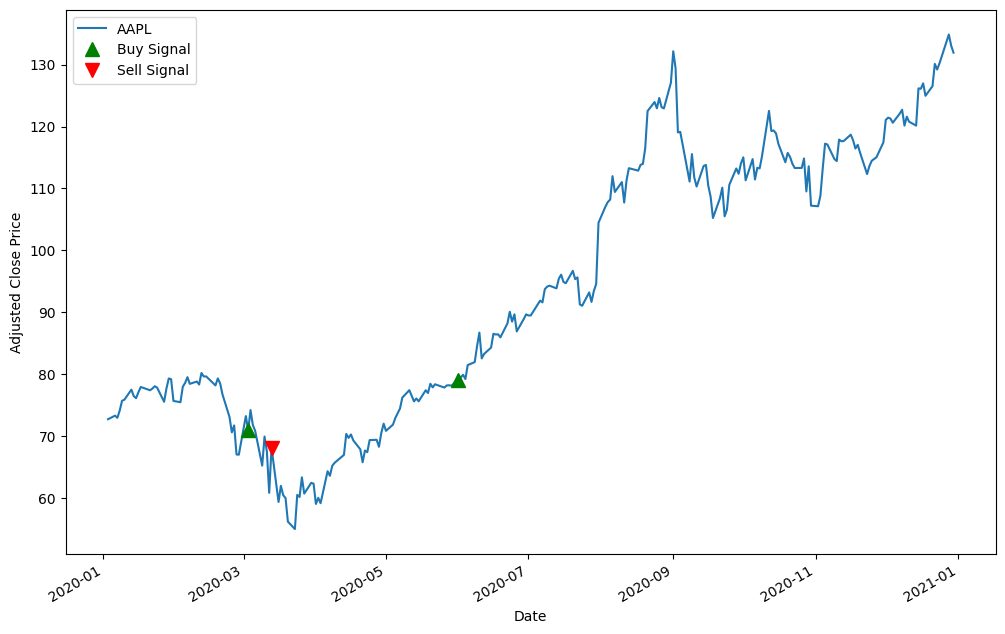

            AAPL  holdings      cash     total  returns
Date                                                   
2020-01-03   NaN       0.0  100000.0  100000.0      NaN
2020-01-06   0.0       0.0  100000.0  100000.0      0.0
2020-01-07   0.0       0.0  100000.0  100000.0      0.0
2020-01-08   0.0       0.0  100000.0  100000.0      0.0
2020-01-09   0.0       0.0  100000.0  100000.0      0.0


In [9]:
def backtest(data, signals):
    positions = pd.DataFrame(index=signals.index).fillna(0.0)
    positions[ticker] = 100 * signals['positions']
    
    portfolio = positions.multiply(data['Adj Close'], axis=0)
    pos_diff = positions.diff()
    
    portfolio['holdings'] = (positions.multiply(data['Adj Close'], axis=0)).sum(axis=1)
    portfolio['cash'] = 100000 - (pos_diff.multiply(data['Adj Close'], axis=0)).sum(axis=1).cumsum()
    
    portfolio['total'] = portfolio['cash'] + portfolio['holdings']
    portfolio['returns'] = portfolio['total'].pct_change()

    plot_trades(data, signals)
    
    return portfolio

def plot_trades(data, signals):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot stock price
    data['Adj Close'].plot(ax=ax, label=ticker)
    
    # Plot buy signals
    ax.plot(signals.loc[signals.positions == 1.0].index, data['Adj Close'][signals.positions == 1.0], '^', markersize=10, color='g', label='Buy Signal')
    
    # Plot sell signals
    ax.plot(signals.loc[signals.positions == -1.0].index, data['Adj Close'][signals.positions == -1.0], 'v', markersize=10, color='r', label='Sell Signal')
    
    ax.set_ylabel('Adjusted Close Price')
    ax.set_xlabel('Date')
    ax.legend(loc='best')
    plt.show()

portfolio = backtest(data, signals)
print(portfolio.head())
